In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm

# Архитектура встраивания

In [4]:
class ConNormAct(nn.Module):
  def __init__(self, in_nf, out_nf):
    super().__init__()

    self.conv = nn.Conv2d(in_nf, out_nf, 4, padding = 1, stride = 2, bias = False)
    self.norm = nn.BatchNorm2d(out_nf)
    self.act = nn.LeakyReLU()

  def forward(self, x):
    out = self.conv(x)
    out = self.norm(out)
    out = self.act(out)

    return out

In [5]:
class DeConNormAct(nn.Module):
  def __init__(self, in_nf, out_nf):
    super().__init__()

    self.deconv = nn.ConvTranspose2d(in_nf, out_nf, 4, padding= 1, stride=2, bias= False)
    self.norm = nn.BatchNorm2d(out_nf)
    self.act = nn.ReLU()

  def forward(self, x):
    out = self.deconv(x)
    out = self.norm(out)
    out = self.act(out)

    return out

In [6]:
class UnetBlock(nn.Module):

  def __init__(self, in_nf,nf, modul = None):
    super().__init__()

    self.conv = ConNormAct(in_nf, nf)
    self.modul = modul
    self.deconv = DeConNormAct(nf, in_nf)
    self.conv_cat = nn.Conv2d(2*in_nf, in_nf, 3, padding=1)

  def forward(self, x):
    out = self.conv(x)
    if self.modul is not None:
      out = self.modul(out)
    out = self.deconv(out)
    out = torch.cat((x, out), axis=1)
    out = self.conv_cat(out)

    return out

In [7]:
class Unet(nn.Module):
  def __init__(self, in_nf=2, nf = 128, out_nf = 1):
    super().__init__()
    self.conv_st = nn.Conv2d(in_nf, nf, 3, padding=1, stride = 1)
    self.act0 = nn.LeakyReLU()


    block = UnetBlock(nf*4, nf*4)
    block = UnetBlock(nf*4, nf*4, block)
    block = UnetBlock(nf*4, nf*4, block)
    block = UnetBlock(nf*2, nf*4, block)
    self.block = UnetBlock(nf, nf*2, block)

    self.conv_fin = nn.Conv2d(nf, out_nf, 3, padding=1, stride = 1)
    self.act1 = nn.Sigmoid()

  def forward(self, x):
    out = self.conv_st(x)
    out = self.act0(out)
    out = self.block(out)
    out = self.conv_fin(out)
    out = self.act1(out)

    return out

# Архитектура сети извлечения

In [8]:
class ConNormAct_ext(nn.Module):
  def __init__(self, in_nf, out_nf):
    super().__init__()

    self.conv = nn.Conv2d(in_nf, out_nf, 3, stride = 1, padding = 1)
    self.norm = nn.BatchNorm2d(out_nf)
    self.act = nn.ReLU()

  def forward(self, x):
    out = self.conv(x)
    out = self.norm(out)
    out = self.act(out)

    return out

In [9]:
class Extraction(nn.Module):
  def __init__(self, in_nf = 1, nf = 64):
    super().__init__()

    self.layer0 = ConNormAct_ext(in_nf, nf)
    self.layer1 = ConNormAct_ext(nf, 2*nf)
    self.layer2 = ConNormAct_ext(2*nf, 4*nf)
    self.layer3 = ConNormAct_ext(4*nf, 2*nf)
    self.layer4 = ConNormAct_ext(2*nf, nf)

    self.conv = nn.Conv2d(nf, in_nf, 3, padding =1, stride = 1)
    self.act = nn.Sigmoid()

  def forward(self, x):
    out = self.layer0(x)
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)

    out = self.conv(out)
    out = self.act(out)

    return out

# Объединение

In [10]:
class MultyNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.unet = Unet()
    self.extr = Extraction()

  def forward(self, con, mark):
    vstr = self.unet(torch.cat((con, mark), axis=1))
    izvl = self.extr(vstr)

    return vstr, izvl


# Datasets&Dataloader

In [ ]:
from google.colab import files
!unzip '/content/database.zip' -d '/content'

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
import cv2
import torchvision.transforms.functional as TF
import os

In [14]:
os.remove('/content/database/countainers/.DS_Store')
os.remove('/content/database/watermarks/.DS_Store')

In [12]:
class MyDataset(torch.utils.data.Dataset):
  def __init__( self, papka_dir0:str, papka_dir1:str):
    super().__init__()

    self.papka_dir0 = papka_dir0
    self.papka_dir1 = papka_dir1

    self.dir0_list = sorted(os.listdir(papka_dir0))
    self.dir1_list = sorted(os.listdir(papka_dir1))

  def __len__(self):
    return min(len(self.dir0_list) , len(self.dir1_list))

  def __getitem__(self, index):
    image0 = os.path.join(self.papka_dir0,
                                self.dir0_list[index])
    image1 = os.path.join(self.papka_dir1,
                                self.dir1_list[index])

    container = cv2.imread(image0, cv2.IMREAD_GRAYSCALE)
    watermark = cv2.imread(image1, cv2.IMREAD_GRAYSCALE)
    if container is not None:
      container = container.astype(np.float32)/255.0
      watermark = watermark.astype(np.float32)/255.0
    else:
      print(dir0_list[index])
      return None

    container = TF.to_tensor(container)
    watermark = TF.to_tensor(watermark)

    return container, watermark

In [15]:
containers = '/content/database/countainers'
watermarks = '/content/database/watermarks'

Dataset = MyDataset(containers, watermarks)

In [16]:
Dataset.__len__()

4734

In [17]:

batch_size = 32

train_loader = torch.utils.data.DataLoader(
    Dataset, shuffle = True, batch_size = batch_size,
    drop_last=True, num_workers=1
    )
model = MultyNet()

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [18]:
epochs = 3
loss_epochs_list = []
for epoch in range(epochs):
  loss_val = 0
  for pics in (pbar := tqdm(train_loader)):
    if pics is not None:
      con, mark = pics
      optimizer.zero_grad()

      vnedr, izvlech = model(con, mark)

      loss = loss_fn(torch.cat((vnedr, izvlech),axis=1), torch.cat((con, mark), axis=1))
      loss.backward()
      loss_item = loss.item()
      loss_val += loss_item

      optimizer.step()
  loss_epochs_list += [loss_val/len(train_loader)]
  print(f'loss:{loss_epochs_list[-1]}')


100%|██████████| 147/147 [1:48:32<00:00, 44.30s/it]


loss:0.014707839059434374


100%|██████████| 147/147 [1:48:02<00:00, 44.10s/it]


loss:0.004822831304718544


100%|██████████| 147/147 [1:47:41<00:00, 43.96s/it]

loss:0.0037879409255827364


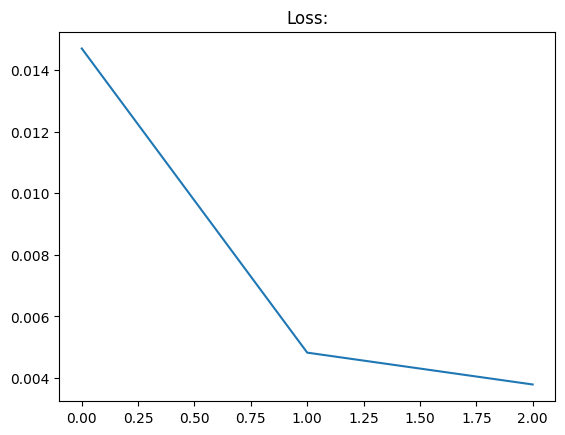

In [19]:
import matplotlib.pyplot as plt
plt.title('Loss:')
plt.plot(loss_epochs_list)

In [22]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Unet.pth')

Проверка результатов

In [ ]:
model = MultyNet()
model.load_state_dict(torch.load('/content/drive/MyDrive/Unet.pth'))
model.train(False)

In [62]:
import matplotlib.pyplot as plt
for i in train_loader:
  container, marka = i
  block = i

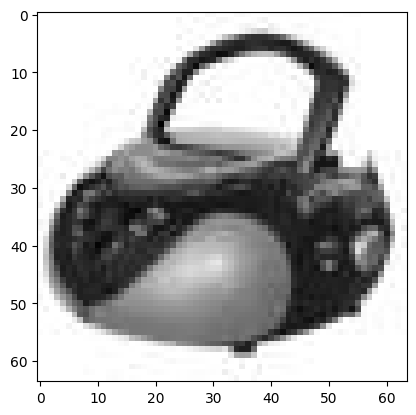

In [68]:
plt.imshow(container.numpy()[0].transpose(1,2,0), cmap="gray" )

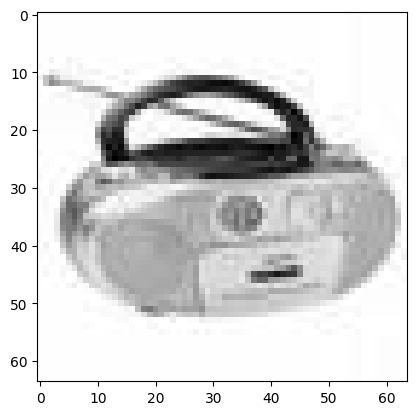

In [69]:
plt.imshow(marka.numpy()[0].transpose(1,2,0), cmap="gray" )


In [65]:
vnedr, izvlech = model(container[0].unsqueeze(0), marka[0].unsqueeze(0))
vnedr = F.sigmoid(vnedr.detach()).numpy()[0].transpose(1,2,0)
izvlech = F.sigmoid(izvlech.detach()).numpy()[0].transpose(1,2,0)

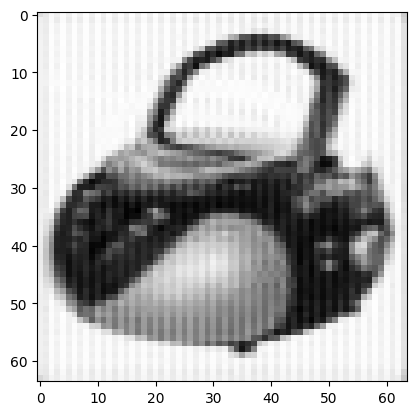

In [66]:
plt.imshow(vnedr, cmap="gray" )

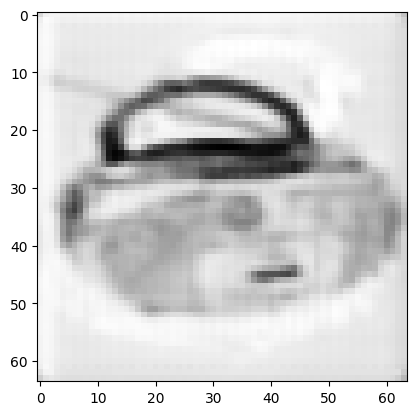

In [67]:
plt.imshow(izvlech, cmap="gray" )